# Convolutional Neural Network mit Feature Extraction
In diesem Notebook wird die Feature Extraction zur Verbesserung der Vorhersage von Katze und Hund das vortrainierte Modell "Imagenet" verwendet. Die Codes stammen aus dem Buch von Chollet (2018).

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import os, shutil

import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

2024-05-10 18:51:27.979896: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 18:51:28.669381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'module://matplotlib_inline.backend_inline'

## Loading Data

In [2]:
original_dataset_dir = '../Aufgabenblatt_4_CNN/dogsvscats/train'

base_dir = '../Aufgabenblatt_4_CNN/dogsvscats_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

## Control of the data

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dogs images:', len(os.listdir(train_cats_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dogs images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dogs images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dogs images: 1000
total validation cat images: 500
total validation dogs images: 500
total test cat images: 500
total test dogs images: 500


## Data Preparation

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 20

## Convolutional Base

In [5]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))

2024-05-10 18:51:57.154807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6789 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:21:00.0, compute capability: 7.5


In [6]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Extract Feature Map

In [7]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


I0000 00:00:1715359928.304317    9669 service.cc:145] XLA service 0x7ff630044380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715359928.304396    9669 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-10 18:52:08.316832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 18:52:08.382866: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


I0000 00:00:1715359930.700900    9669 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

## Reshape the Tensors for Input in Dense Layers

In [9]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_featues = np.reshape(test_features, (1000, 4*4*512))

## Model building

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

/home/staudtyves/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model compile

In [11]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

## Model Fit

In [12]:
history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.6275 - loss: 0.6571 - val_acc: 0.8210 - val_loss: 0.4504
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7932 - loss: 0.4625 - val_acc: 0.8200 - val_loss: 0.3899
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8474 - loss: 0.3499 - val_acc: 0.8660 - val_loss: 0.3308
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8572 - loss: 0.3398 - val_acc: 0.8840 - val_loss: 0.2989
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8884 - loss: 0.2852 - val_acc: 0.8890 - val_loss: 0.2874
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9039 - loss: 0.2512 - val_acc: 0.8950 - val_loss: 0.2748
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9101 - loss: 0.2383 - val_acc: 0.8820 - val_loss: 0.2780
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9169 - loss: 0.2193 - val_acc: 0.8960 - val_loss: 0.2628
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

## Model Evaluation

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

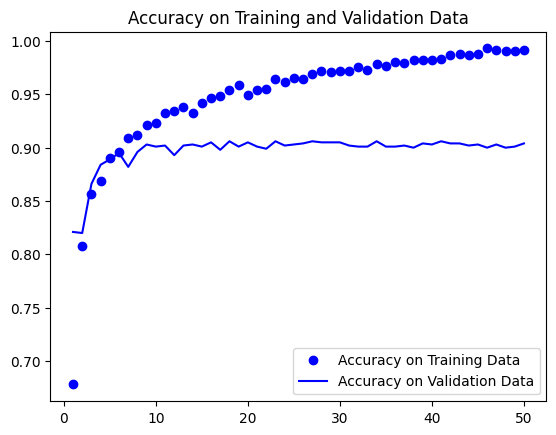

In [14]:
plt.plot(epochs, acc, 'bo', label = 'Accuracy on Training Data')
plt.plot(epochs, val_acc, 'b', label = 'Accuracy on Validation Data')
plt.title('Accuracy on Training and Validation Data')
plt.legend()
plt.show()

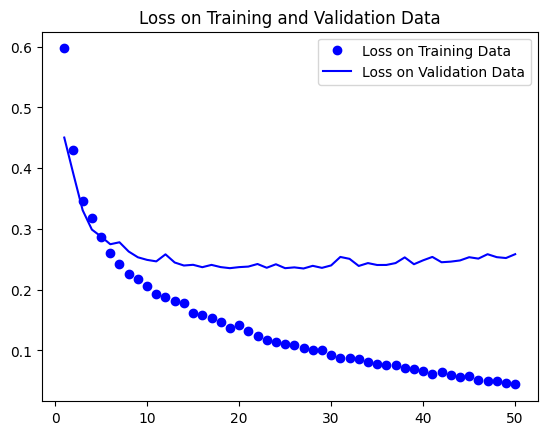

: 

In [15]:
plt.plot(epochs, loss, 'bo', label = 'Loss on Training Data')
plt.plot(epochs, val_loss, 'b', label = 'Loss on Validation Data')
plt.title('Loss on Training and Validation Data')
plt.legend()
plt.show()

## REFERENCES
Francois Chollet (2018), Deep Learning with Keras, Manning.